## Building Multi-Phase Trajectory with UQPCE and Dymos
This problem demonstrates how to collectively use the UQPCE, Dymos, and OpenMDAO frameworks together.

### Indoor Shot Put
Consider an indoor shot put game. The goal is to solve for optimal values of mass and velocity so the metal ball reaches as close as possible to the target 150m away, subject to physical constraints.

![Indoor sport](trajectory_img.png "Indoor sport")

#### This example is a demonstration of a simple projectile motion problem design under uncertainty.
- **Dymos** is used for implementation of the differential equations of motion and mapping of trajectory paths.
- **UQPCE** is used to develop a polynomial-chaos expansion surrogate model, where sample points of the uncertain variables are provided.
- UQPCE is connected to Dymos in this problem using the framework of **OpenMDAO**.

### Problem Composition
The drag coefficient and angle relative to the ground are represented by uncertain variables, sampled from uniform and normal distributions, respectively. The distribution for the drag coefficient ranges from 0.1 to 0.9. The distribution for the angle *theta* has a mean of 30 and standard deviation of 2.\
\
Each trajectory correlates to uncertain sample values for drag coefficient and angle. The trajectory is composed of two phases, ascent and descent.

The problem iterates to find the design variable (mass and velocity) values which optimize the objective function.
### Variables
* `A` - Projectile surface area (dependent on mass)
* `m` - Mass (design variable)
* `v` - Velocity (design variable)
* `g` - Acceleration due to gravity (constant)
* `rho_0` - Density of air (constant)
* `vx` - Velocity x-component (dependent on velocity and theta)
* `vy` - Velocity y-component (dependent on velocity and theta)
* `c_d` - Drag coefficient (uncertain variable)
* `theta` - Angle (uncertain variable)

### Components
- **Obj** (objective): This component motivates the problem to optimize towards a mean x-distance of 150.
- **Cost** (constraint): This component defines cost in terms of kinetic energy.
- **WidthCI** (constraint): This component constrains the upper bound of the confidence interval width, encouraging less variance.
- **Area** (computation): The component is used to connect the current value of mass into the computation for cross-sectional area.
- **V_Comp** (computation): This component separates the velocity vector into its respective x and y components.
- **EOM** (computation): This component defines the equations of motion for the trajectories in this problem.

![xdsm](traj_xdsm.png "XDSM")

In [1]:
#
#   Polynomial Chaos Expansion of parabolic flight
#   distance optimization with OpenMDAO and Dymos
#

# Problem Design:
#   Uncertain variables -- Drag-coefficient and launch angle
#   Design variables    -- Velocity and mass
#   Objective           -- target distance
#   Constraint          -- cost (proportional to velocity/mass), CI width, y-height maximum

import openmdao.api as om
import dymos as dm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import jax.numpy as jnp
import jax.nn as jnn
import fitz
from uqpce import PCE
from uqpce.mdao import interface
from uqpce.mdao.uqpcegroup import UQPCEGroup
from openmdao.core.parallel_group import ParallelGroup
from IPython.display import display
from PIL import Image

%matplotlib inline

### Cost Constraint
In this problem, cost is evaluated as a constraint, taking inputs of *mass* and *velocity* and computing kinetic energy. This constraint is bounded between 500 and 5000.
$$
KE(m, v) = \frac{1}{2}mv^2
$$

In [2]:
class Cost(om.ExplicitComponent):
    """
    OpenMDAO Explicit Component which computes cost using Kinetic Energy,
    a function of mass and velocity. Component behaves as a constraint.
    Underlying functionality transforms velocity from scalar to vector and
    feeds mass directly through input to output.
    """
    def initialize(self):
        self.options.declare('num_samples', types=int)

    def setup(self):
        n = self.options['num_samples']
        self.add_input('v', units='m/s')
        self.add_input('m', units='kg')

        self.add_output('cost', units='m')
        self.add_output('v_out', shape=(n,), units='m/s')
        self.add_output('m_out', units='kg')

    def setup_partials(self):
        self.declare_partials(of='m_out', wrt='m', val=1.0)
        self.declare_partials(of='v_out', wrt='v', val=1.0)
        self.declare_partials(of='cost', wrt='m')
        self.declare_partials(of='cost', wrt='v')
    
    def compute(self, inputs, outputs):
        n = self.options['num_samples']
        outputs['cost'] = 0.5 * inputs['m'] * inputs['v'] ** 2
        outputs['v_out'] = np.repeat(inputs['v'], n)
        outputs['m_out'] = inputs['m']

    def compute_partials(self, inputs, partials):
        partials['cost', 'v'] = inputs['m'] * inputs['v']
        partials['cost', 'm'] = 0.5 * inputs['v'] ** 2

### Confidence Interval Width
The width of the confidence interval for x-distance is evaluated as a constraint, computing the difference between upper and lower CI.
$$
CI_{diff} = CIU - CIL
$$

In [3]:
class WidthCI(om.ExplicitComponent):
    """
    OpenMDAO Explicit Component which computes the difference between
    upper and lower confidence interval bounds (with respect to distance traveled).
    Component behaves as a constraint.
    """
    def setup(self):
        self.add_input('x_out:ci_lower')
        self.add_input('x_out:ci_upper')
        self.add_output('width')

    def setup_partials(self):
        self.declare_partials(of='width', wrt='x_out:ci_lower')
        self.declare_partials(of='width', wrt='x_out:ci_upper')

    def compute(self, inputs, outputs):
        outputs['width'] = inputs['x_out:ci_upper'] - inputs['x_out:ci_lower']

    def compute_partials(self, inputs, partials):
        partials['width', 'x_out:ci_lower'] = -1.0
        partials['width', 'x_out:ci_upper'] = 1.0


### Velocity Components
The V_Comp component is a method of computation to compute x-velocity and y-velocity components given the initial velocity of the problem and theta angle for each sample point.
$$
V_x(v, \theta) = vcos(\theta)
$$
$$
V_y(v, \theta) = vsin(\theta)
$$

In [4]:
class V_Comp(om.ExplicitComponent):
    """
    OpenMDAO Explicit Component which computes x and y velocity components
    provided the angle theta and initial velocity.
    """
    def initialize(self):
        self.options.declare('num_samples', types=int)

    def setup(self):
        n = self.options['num_samples']

        self.add_input('v_in', shape=(n,), units='m/s')
        self.add_input('theta', shape=(n,), units='rad')

        self.add_output('vx', shape=(n,), units='m/s')
        self.add_output('vy', shape=(n,), units='m/s')

    def setup_partials(self):
        n = self.options['num_samples']
        ar = np.arange(n, dtype=int)
        self.declare_partials('*', '*', rows=ar, cols=ar)

    def compute(self, inputs, outputs):
        th_rad = inputs['theta']
        vx = inputs['v_in']*jnp.cos(th_rad)
        vy = inputs['v_in']*jnp.sin(th_rad)

        outputs['vx'] = vx
        outputs['vy'] = vy

    def compute_partials(self, inputs, partials):
        n = self.options['num_samples']
        th_rad = inputs['theta']
        partials['vx', 'theta'] = inputs['v_in'] * (-1)*np.sin(th_rad)
        partials['vx', 'v_in'] = np.cos(th_rad)
        partials['vy', 'theta'] = inputs['v_in'] * np.cos(th_rad)
        partials['vy', 'v_in'] = np.sin(th_rad)

### Cross-sectional Area
The Area component is a method of computation to determine the cross-sectional area of the projectile provided its mass.
$$
m = \rho\frac{4}{3}\pi{r}^3 \Leftrightarrow r = \sqrt[3]{\frac{3}{4}*\frac{m}{9340}*\frac{1}{\pi}}
$$
$$
A = \pi{r}^2
$$
Mass is a design variable that changes throughout the optimization. Since cross-sectional area depends on mass and the density is constant, the radius needs to be re-computed each iteration, which is then used to re-compute area.

In [5]:
class Area(om.ExplicitComponent):
    """
    OpenMDAO Explicit Component which computes surface area provided
    the mass of the projectile.
    """
    def setup(self):
        self.add_input('m', units='kg')
        self.add_output('A', units='m**2')

    def setup_partials(self):
        self.declare_partials(of='A', wrt='m')

    def compute(self, inputs, outputs):
        # Density = 9340 kg/m^3 for metal ball
        const = 3 / (4*np.pi*9340)
        m = inputs['m']
        
        outputs['A'] = np.pi * (const * m)**(2/3)

    def compute_partials(self, inputs, partials):
        const = 3 / (4*np.pi*9340)
        m = inputs['m']

        partials['A', 'm'] = ((2*np.pi)/3) * ((1/(const*m))**(1/3)) * const

### Equations of Motion
A **Dymos** trajectory is constructed using the equations of motion and derivatives for a projectile. This component is representative of the differential equations required to interpolate the trajectory values at a set of nodes along the curve.
$$
\theta = arctan(\frac{V_y}{V_x})
$$
$$
\rho = \rho_{0}e^{\frac{-y}{8500}}
$$
$$
v = \sqrt{v_{x}^2 + v_{y}^2}
$$
$$
D = \frac{1}{2}\rho{v}^2{c_D}A
$$

In [6]:
class EOM(om.JaxExplicitComponent):
    """
    Jax Explicit Component which computes the equations of motion used by Dymos
    for trajectory interpolation.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input('y', shape=(nn,), units='m')
        self.add_input('vx', shape=(nn,), units='m/s')
        self.add_input('vy', shape=(nn,), units='m/s')
        self.add_input('c_d', shape=(1), units='unitless')
        self.add_input('A', shape=(1), units='m**2')
        self.add_input('m', shape=(1), units='kg')
        self.add_input('g', shape=(1), val=9.80665, units='m/s**2')
        self.add_input('rho_0', shape=(1), val=1.22, units='kg/m**3')

        self.add_output('x_dot', shape=(nn,), units='m/s', tags=['dymos.state_rate_source:x', 'dymos.state_units:m'])
        self.add_output('y_dot', shape=(nn,), units='m/s', tags=['dymos.state_rate_source:y', 'dymos.state_units:m'])
        self.add_output('vx_dot', shape=(nn,), units='m/s**2', tags=['dymos.state_rate_source:vx', 'dymos.state_units:m/s'])
        self.add_output('vy_dot', shape=(nn,), units='m/s**2', tags=['dymos.state_rate_source:vy', 'dymos.state_units:m/s'])
        self.add_output('v', shape=(nn,), units='m/s')
    
    def compute_primal(self, y, vx, vy, c_d, A, m, g, rho_0):
        theta = jnp.arctan2(vy, vx)
        rho = rho_0*jnp.exp(-y/8500)
        v = jnp.sqrt(vx**2 + vy**2)
        D = 0.5*rho*(v**2)*c_d*A

        vx_dot = (-D/m) * jnp.cos(theta)
        vy_dot = -g - (D/m) * jnp.sin(theta)
        x_dot = vx
        y_dot = vy

        return x_dot, y_dot, vx_dot, vy_dot, v

### Objective
The objective for this problem is to optimize design variables such that constraints are followed and the projectile reaches the nearest possible x-distance to the target value (which is set to 150m in this problem).
$$
f(\mu, \sigma^{2}) = ({150-\mu})^2+\sigma^{2}
$$

In [7]:
class Obj(om.ExplicitComponent):
    """
    OpenMDAO Explicit Component which defines the problem objective.
    The goal is for the trajectory mean to be a minimum distance from
    the target value.
    """
    def initialize(self):
        self.options.declare('num_samples', types=int)

    def setup(self):
        self.add_input('x_out:mean')
        self.add_input('x_out:variance')

        self.add_output('obj')
    
    def setup_partials(self):
        self.declare_partials(of='obj', wrt='x_out:mean')

    def compute(self, inputs, outputs):
        tgt = 150
        
        outputs['obj'] = (tgt - inputs['x_out:mean']) ** 2

    def compute_partials(self, inputs, partials):
        tgt = 150

        partials['obj', 'x_out:mean'] = -2 * (tgt - inputs['x_out:mean'])



### Contour Plots
Visualizations showing how x-distance changes as a design variable is scaled, with the other design variable held at a constant, optimal value.

In [8]:
def dv_contour(prob):
    """
    Generates contour plots pertaining to each design variable
    and how the objective changes with small steps in the current
    design variable.
    """
    # m design variable #
    des_m = np.linspace(1, 4, 10)
    dv_cnt = len(des_m)
    bin_cnt = 100
    pl = 0.05/2
    ph = 1-pl
    uncert_resp = np.zeros((des_m.shape[0], 500000))
    for idx in range(0, len(des_m)):
        prob.set_val('m', des_m[idx])
        prob.set_val('v', 42.57)
        prob.run_model()
        r = prob.get_val('x_out:resampled_responses')
        uncert_resp[idx, :] = r


    means = np.mean(uncert_resp, axis=1)
    cils = np.quantile(uncert_resp, pl, axis=1)
    cihs = np.quantile(uncert_resp, ph, axis=1)

    counts = np.zeros([dv_cnt, bin_cnt])
    bin_edges = np.zeros([dv_cnt, bin_cnt+1])
    pdfs = np.zeros([dv_cnt, bin_cnt])
    for i in range(dv_cnt):
        counts[i,:], bin_edges[i,:] = np.histogram(uncert_resp[i,:], bins=bin_cnt)
        pdfs[i,:] = counts[i,:] / np.max(counts[i,:])
    
    pltrange = [np.ones(bin_cnt)*des_m[i] for i in range(dv_cnt)]
    pltbin = [(bin_edges[i,1:] + bin_edges[i,:-1])/2 for i in range(dv_cnt)]
    pltpdf = [pdfs[i,:] for i in range(dv_cnt)]

    for i in range(dv_cnt):
        pltbin[i][0] = np.min(bin_edges)
        pltbin[i][-1] = np.max(bin_edges)


    fig = plt.figure(figsize=(10,7), dpi=300)
    ax = plt.subplot(111)

    pltData = ax.contourf(
        pltrange, pltbin, pltpdf,
        levels=10, cmap='Blues', alpha=0.95, extend='both'
    )

    cb = plt.colorbar(pltData, ax=ax, pad=0.1)
    cb.ax.set_ylabel('Probability Density')

    ax.set_xlabel('Mass (kg)', fontweight='bold')
    ax.set_ylabel('Distance (m)', color='black', fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3, color='#666666', linewidth=0.75)

    ax.plot(des_m, cils, color='#1f77b4', linestyle='--', label=f'Lower CI (distance)')
    ax.plot(des_m, cihs, color='#d62728', linestyle='--', label=f'Upper CI (distance)')
    ax.plot(des_m, means, color='#ff7f0e', linestyle='-', linewidth=2, label=f'Mean (distance)')

    handles, labels = ax.get_legend_handles_labels()

    fig.subplots_adjust(bottom=0.2)
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    # Add watermark
    plt.figtext(0.99, 0.01, 'Created with UQPCE', 
               fontsize=7, color='#999999', ha='right', va='bottom',
               style='italic')
    
    fig.tight_layout(pad=1.1)




    # v design variable #
    des_v = np.arange(20, 100, 2)
    dv_cnt = len(des_v)
    bin_cnt = 100
    pl = 0.05/2
    ph = 1-pl
    uncert_resp = np.zeros((des_v.shape[0], 500000))
    for idx in range(0, len(des_v)):
        prob.set_val('m', 3.62)
        prob.set_val('v', des_v[idx])
        prob.run_model()
        r = prob.get_val('x_out:resampled_responses')
        uncert_resp[idx, :] = r


    means = np.mean(uncert_resp, axis=1)
    cils = np.quantile(uncert_resp, pl, axis=1)
    cihs = np.quantile(uncert_resp, ph, axis=1)

    counts = np.zeros([dv_cnt, bin_cnt])
    bin_edges = np.zeros([dv_cnt, bin_cnt+1])
    pdfs = np.zeros([dv_cnt, bin_cnt])
    for i in range(dv_cnt):
        counts[i,:], bin_edges[i,:] = np.histogram(uncert_resp[i,:], bins=bin_cnt)
        pdfs[i,:] = counts[i,:] / np.max(counts[i,:])
    
    pltrange = [np.ones(bin_cnt)*des_v[i] for i in range(dv_cnt)]
    pltbin = [(bin_edges[i,1:] + bin_edges[i,:-1])/2 for i in range(dv_cnt)]
    pltpdf = [pdfs[i,:] for i in range(dv_cnt)]

    for i in range(dv_cnt):
        pltbin[i][0] = np.min(bin_edges)
        pltbin[i][-1] = np.max(bin_edges)


    fig = plt.figure(figsize=(10,7), dpi=300)
    ax = plt.subplot(111)

    pltData = ax.contourf(
        pltrange, pltbin, pltpdf,
        levels=10, cmap='Blues', alpha=0.95, extend='both'
    )

    cb = plt.colorbar(pltData, ax=ax, pad=0.1)
    cb.ax.set_ylabel('Probability Density')

    ax.set_xlabel('Velocity (m/s)', fontweight='bold')
    ax.set_ylabel('Distance (m)', color='black', fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3, color='#666666', linewidth=0.75)

    ax.plot(des_v, cils, color='#1f77b4', linestyle='--', label=f'Lower CI (distance)')
    ax.plot(des_v, cihs, color='#d62728', linestyle='--', label=f'Upper CI (distance)')
    ax.plot(des_v, means, color='#ff7f0e', linestyle='-', linewidth=2, label=f'Mean (distance)')

    handles, labels = ax.get_legend_handles_labels()

    fig.subplots_adjust(bottom=0.2)
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    # Add watermark
    plt.figtext(0.99, 0.01, 'Created with UQPCE', 
               fontsize=7, color='#999999', ha='right', va='bottom',
               style='italic')
    
    fig.tight_layout(pad=1.1)
    plt.show()

### Trajectory Definition
Using **Dymos**, this function demonstrates the construction of a multiphase trajectory, composed of ascent and descent. The ascent phase is defined by constraining the trajectory to reach a final y-velocity of 0. The descent phase is defined by constraining the final height to 0. Note the addition of each trajectory to a parallel group.

In [9]:
def traj_init(parallel, i, vals):
    """
    Initialize each Dymos trajectory in parallel using set parameter values
    and sample values. Each trajectory is multi-phase, composed of ascent and
    descent phases.
    """
    # Initialize trajectory of name variation i
    n_traj = 'traj'+str(i)
    traj = dm.Trajectory()
    tx = dm.PicardShooting(num_segments=1, nodes_per_seg=11, solve_segments='forward')
    tx2 = dm.PicardShooting(num_segments=1, nodes_per_seg=11, solve_segments='forward')
    parallel.add_subsystem(n_traj, traj)

    ascent = traj.add_phase('ascent', dm.Phase(ode_class=EOM, transcription=tx))
    
    ascent.set_time_options(fix_initial=True, fix_duration=True)

    ascent.add_state('x', rate_source='x_dot', fix_initial=True, fix_final=False)
    ascent.add_state('y', rate_source='y_dot', fix_initial=True, fix_final=False)
    ascent.add_state('vx', rate_source='vx_dot', input_initial=True, fix_initial=False, fix_final=False)
    ascent.add_state('vy', rate_source='vy_dot', input_initial=True, fix_initial=False, fix_final=False)

    ascent.add_parameter('c_d', units='unitless', val=vals['c_d'])
    ascent.add_parameter('A', units='m**2')
    ascent.add_parameter('g', units='m/s**2', val=vals['g'])
    ascent.add_parameter('rho_0', units='kg/m**3', val=vals['rho_0'])
    ascent.add_parameter('m', units='kg')

    ascent.add_boundary_balance(param='t_duration', name='vy', tgt_val=0.0, loc='final', lower=0.1, upper=100.0)
    ascent.nonlinear_solver = om.NewtonSolver(solve_subsystems=True, maxiter=100, iprint=0, debug_print=True)
    ascent.nonlinear_solver.linesearch = om.ArmijoGoldsteinLS()
    ascent.nonlinear_solver.debug_print = True
    ascent.linear_solver = om.DirectSolver()

    descent = traj.add_phase('descent', dm.Phase(ode_class=EOM, transcription=tx2))
    
    descent.set_time_options(input_initial=True, fix_duration=True)

    descent.add_state('x', rate_source='x_dot', input_initial=True, fix_final=False)
    descent.add_state('y', rate_source='y_dot', input_initial=True, fix_final=False)
    descent.add_state('vx', rate_source='vx_dot', input_initial=True, fix_final=False)
    descent.add_state('vy', rate_source='vy_dot', input_initial=True, fix_final=False)

    descent.add_parameter('c_d', units='unitless', val=vals['c_d'])
    descent.add_parameter('A', units='m**2') #, val=vals['A'])
    descent.add_parameter('g', units='m/s**2', val=vals['g'])
    descent.add_parameter('rho_0', units='kg/m**3', val=vals['rho_0'])
    descent.add_parameter('m', units='kg') #, val=vals['m'])

    descent.add_boundary_balance(param='t_duration', name='y', tgt_val=0.0, loc='final', lower=0.1, upper=100.0)
    descent.nonlinear_solver = om.NewtonSolver(solve_subsystems=True, maxiter=100, iprint=0, debug_print=True)
    descent.nonlinear_solver.linesearch = om.ArmijoGoldsteinLS()
    descent.nonlinear_solver.debug_print = True
    descent.linear_solver = om.DirectSolver()

    traj.link_phases(phases=('ascent', 'descent'), connected=True, vars='*')

    return traj, ascent, descent

In [10]:
# Initial values and ranges defined for phase state variables
def phase_setup(ranges, ascent, descent):
    """
    State initialization for each ascent and descent phase.
    """
    ascent.set_time_val(initial=ranges['t_init'], duration=ranges['t_dur'])
    ascent.set_state_val('x', [ranges['x_init'], ranges['x_dur']])
    ascent.set_state_val('y', [ranges['y_init'], ranges['y_dur']])

    descent.set_time_val(initial=ranges['t_init'], duration=ranges['t_dur'])
    descent.set_state_val('x', [ranges['x_init'], ranges['x_dur']])
    descent.set_state_val('y', [ranges['y_init'], ranges['y_dur']])

### Problem Definition
The problem is initialized with each component above added as a subsystem. Trajectories are defined for each sample point of uncertain variables. The problem is optimized and the resulting trajectories are plotted.

Negative mean squared error

Using an alternate equation

/Users/mbrandt6/miniforge3/envs/uqPCE/lib/python3.12/site-packages/openmdao/core/group.py:2989: UnitsWarning:<model> <class Group>: Output 'mux.x_out' with units of 'm' is connected to input 'UQPCE.x_out_coeff_comp.responses' which has no units.


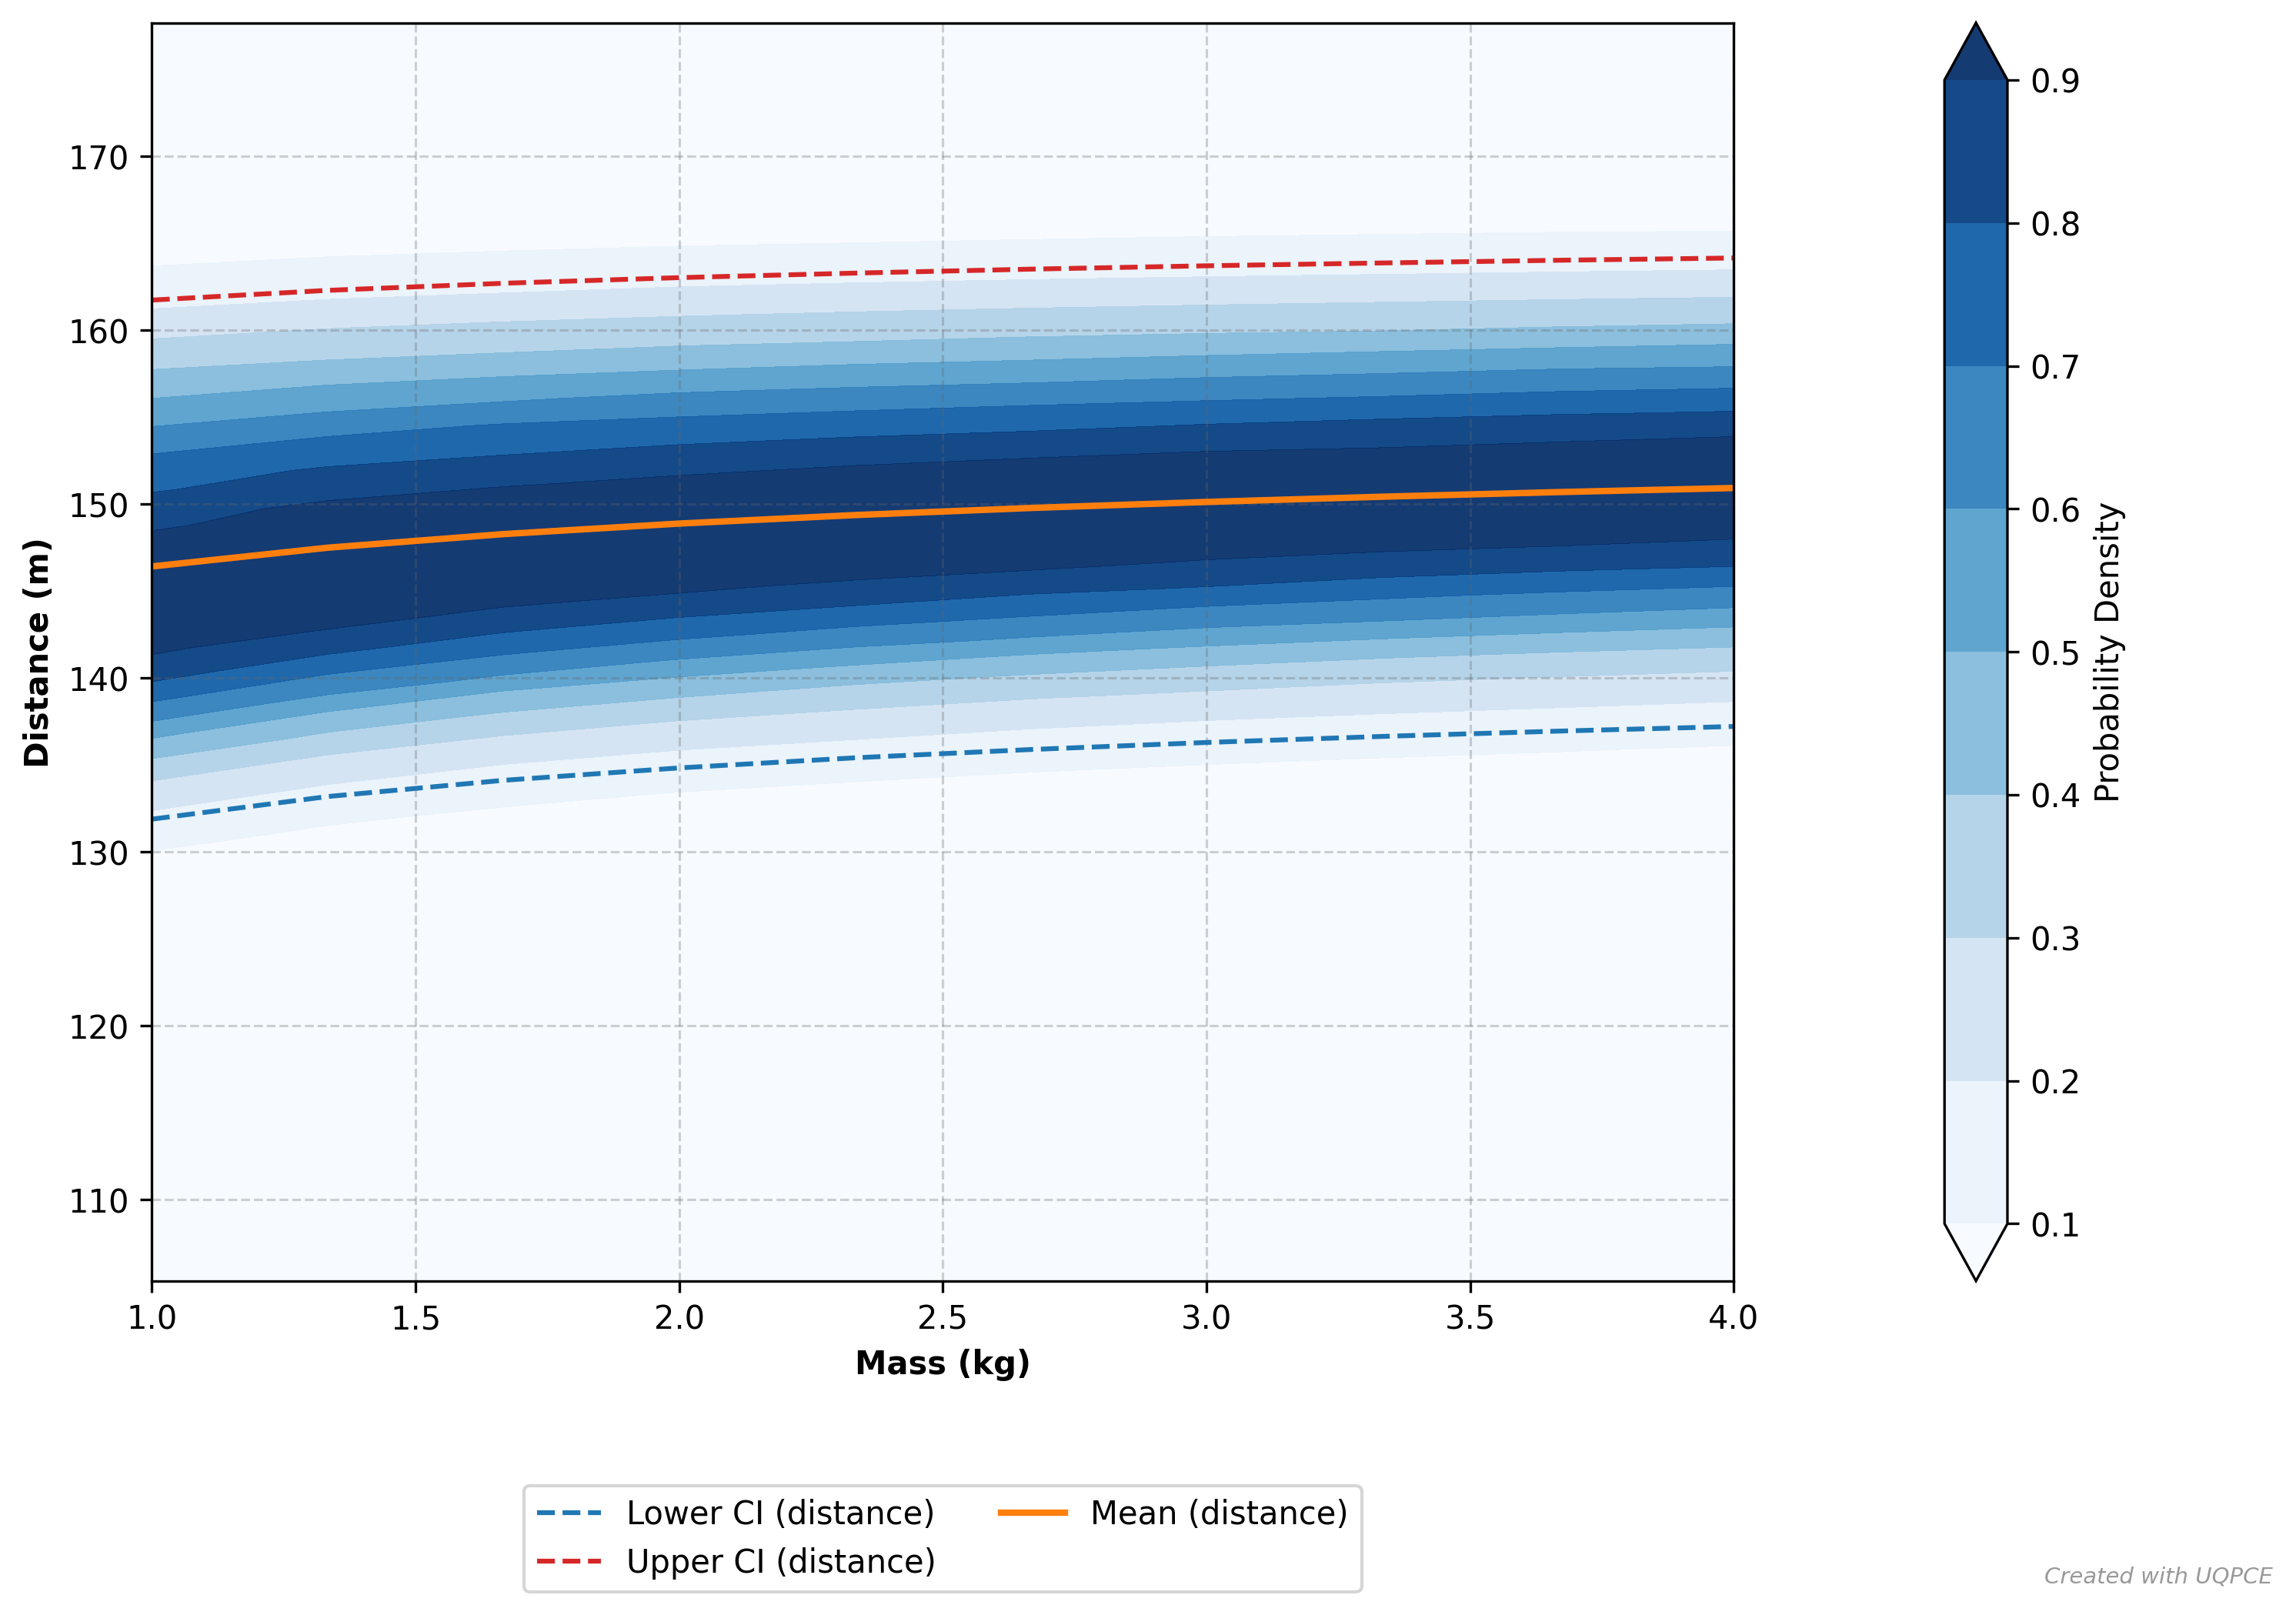

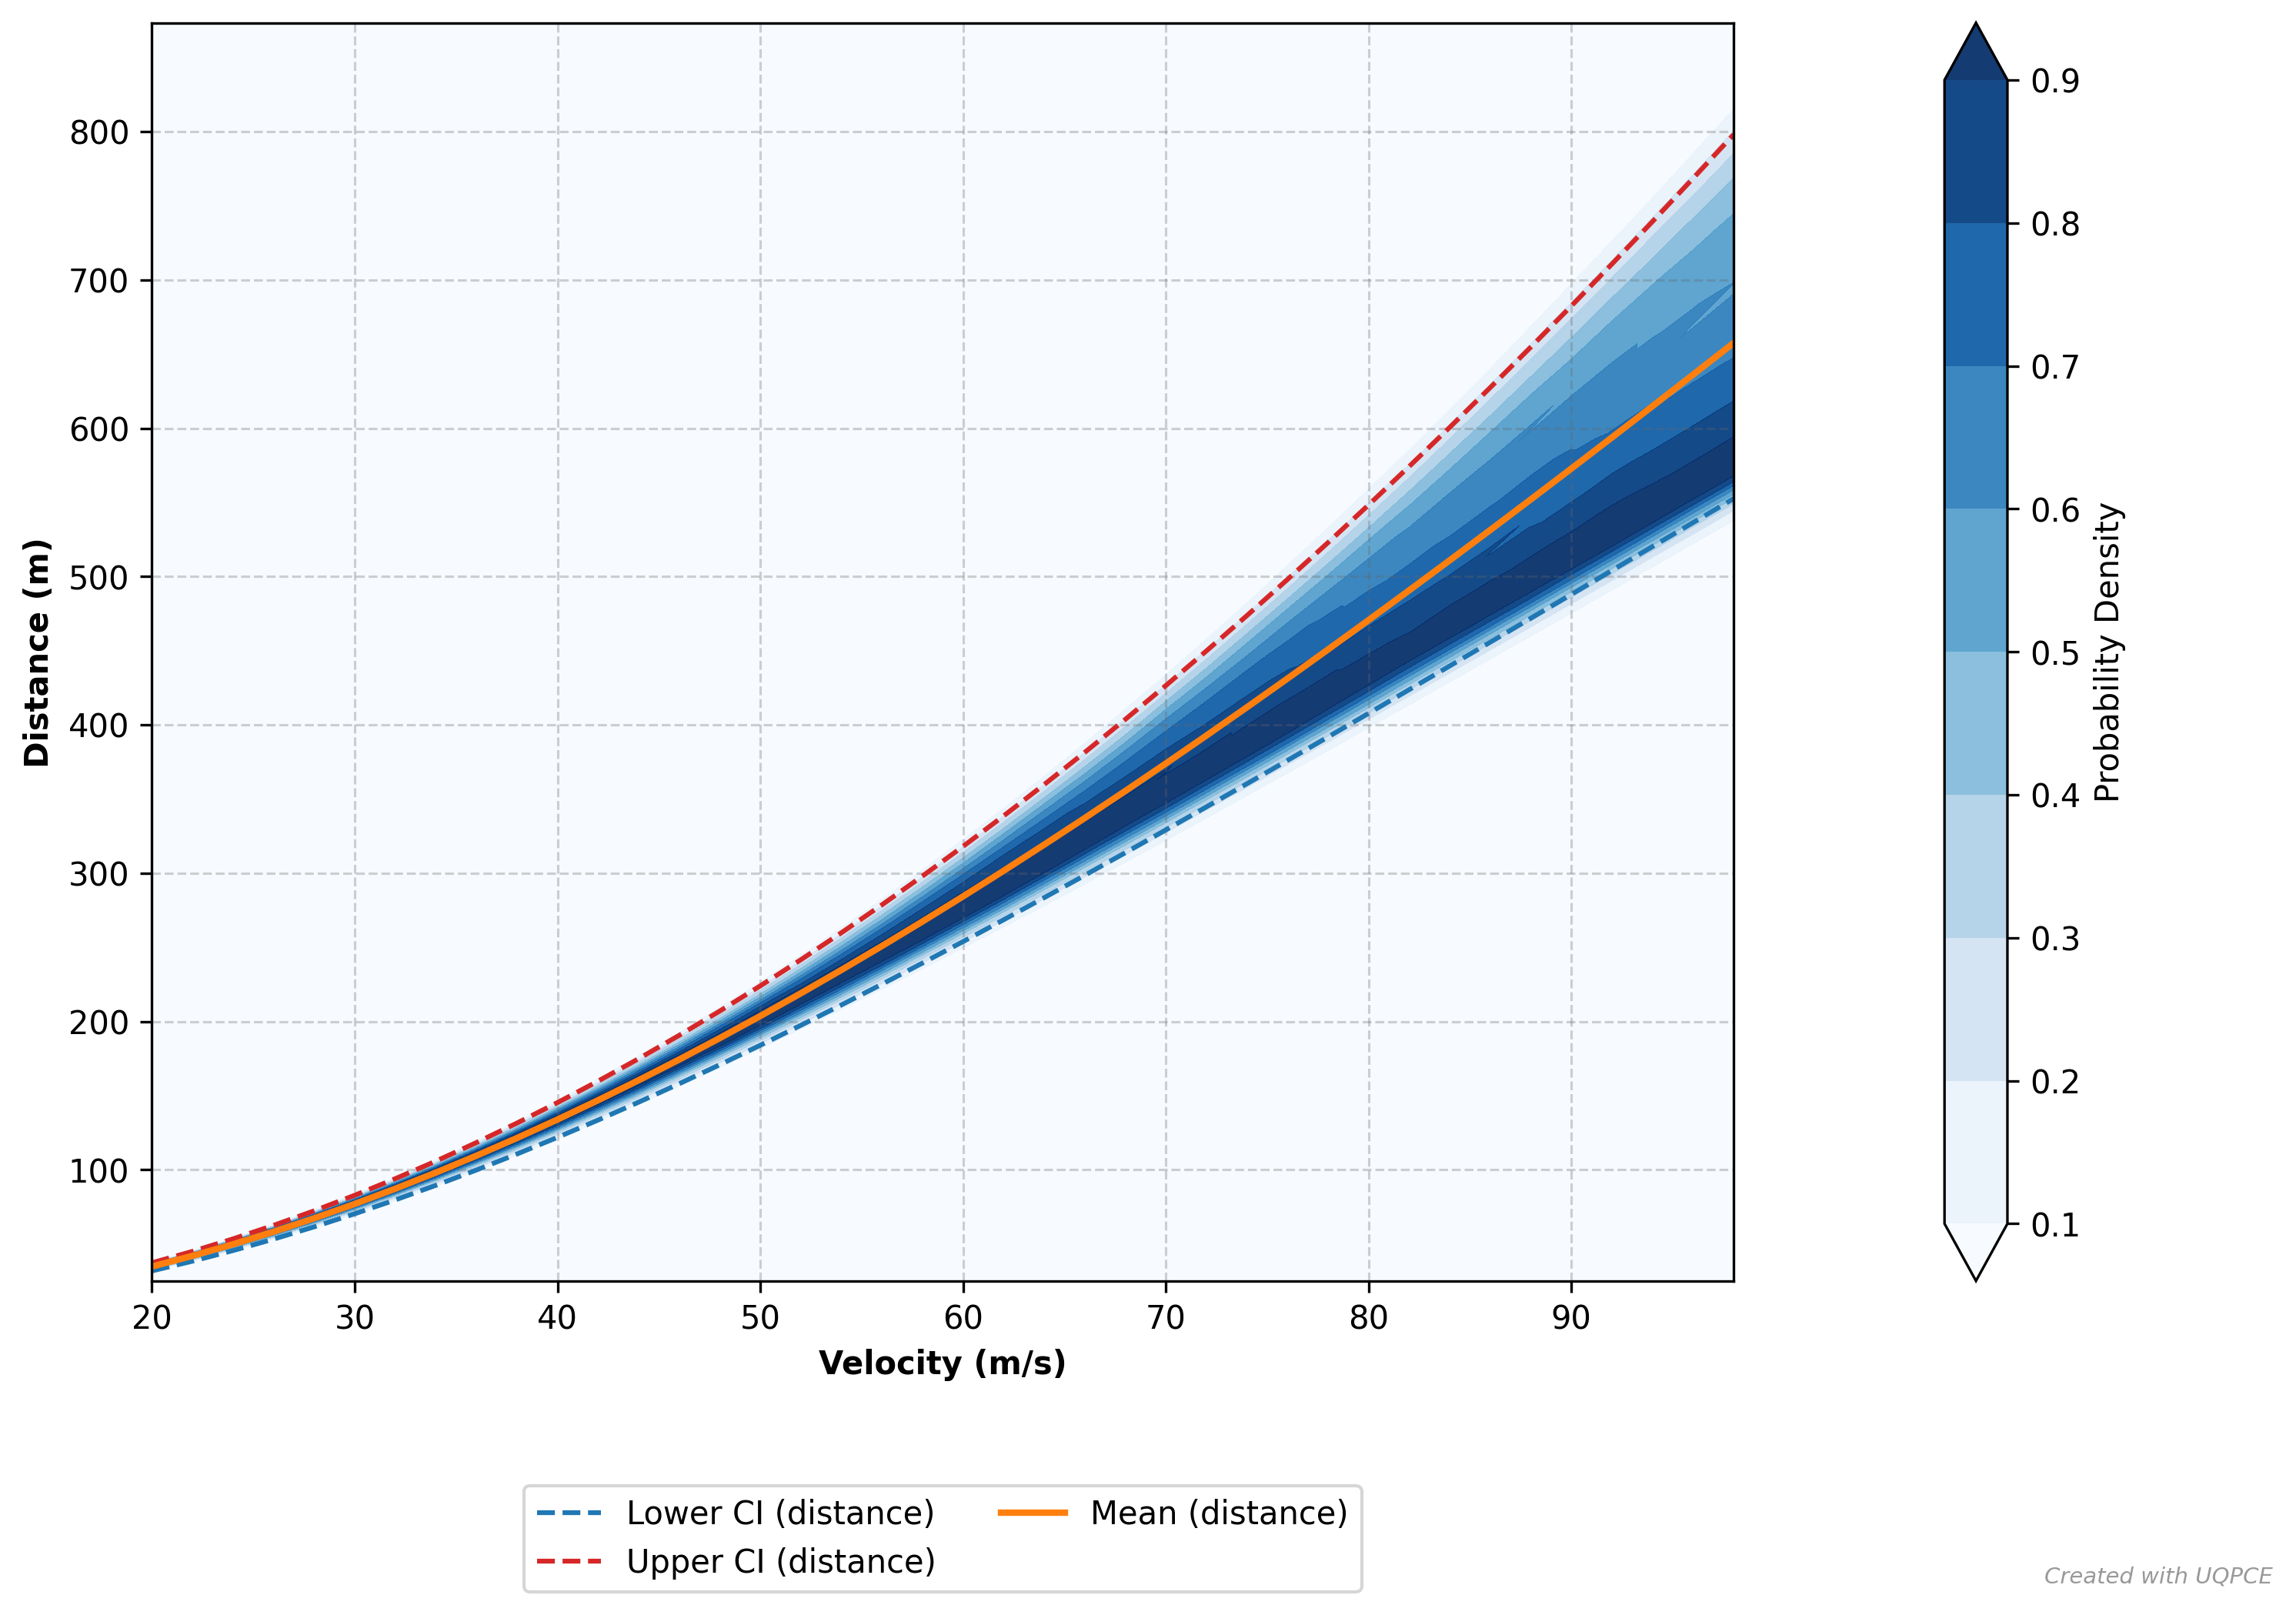

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.19571703571632e-15
            Iterations: 8
            Function evaluations: 12
            Gradient evaluations: 8
Optimization Complete
-----------------------------------


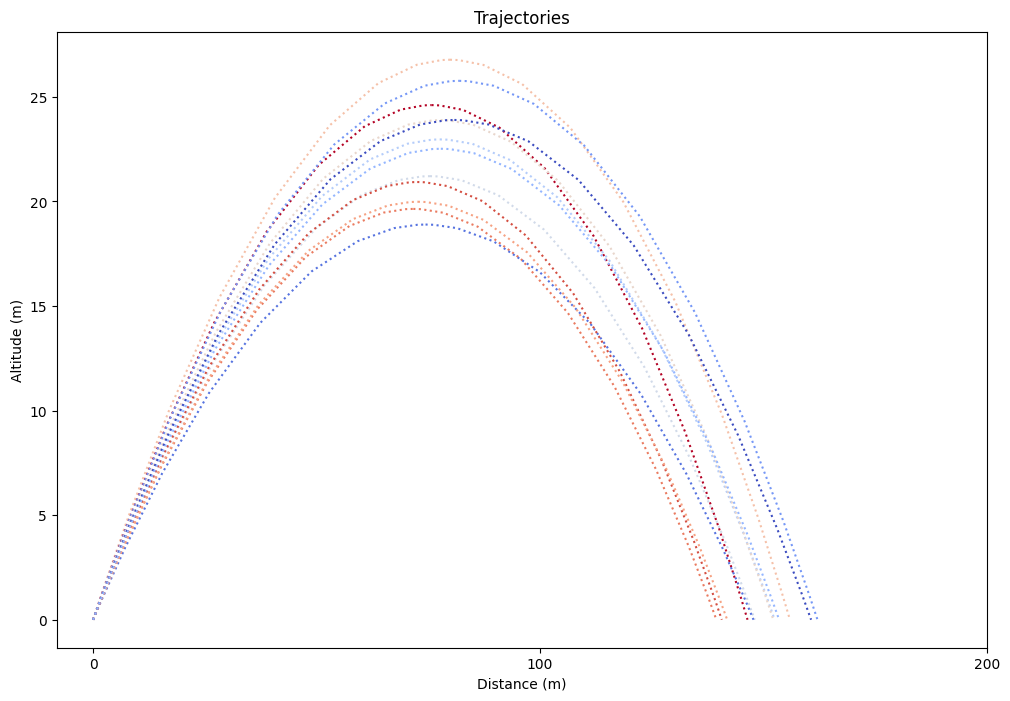

Upper CI is [167.94942073]
Lower CI is [132.56488856]
Mean is [150.00000006]
Variance is [62.35886493]
Design Variable v is [43.04813938]
Design Variable m is [1.14609762]
Cost constraint is [1061.94098728]
Maximum height is 26.77877134624426


In [11]:
def run():
    # Initialize given input files
    input_file = 'drag_angle2.yaml'
    matrix_file = 'matrix_drag2.dat'

    (
        var_basis, norm_sq, resampled_var_basis, 
        aleatory_cnt, epistemic_cnt, resp_cnt, order, variables, 
        sig, run_matrix
    ) = interface.initialize(input_file, matrix_file)

    # Problem setup
    prob = om.Problem()
    
    phases = []
    vals = {
        'c_d': 0.5,
        'A': 0.001,
        'g': 9.80665,
        'rho_0': 1.22,
        'm': 1
    }

    # Cost constraint subsystem
    prob.model.add_subsystem(
        'cost', Cost(num_samples=resp_cnt),
        promotes_inputs=['v', 'm'], promotes_outputs=['cost', 'v_out', 'm_out']
    )

    # Velocity components subsystem
    prob.model.add_subsystem('v_comp', V_Comp(num_samples=resp_cnt), 
                                 promotes_inputs=[('v_in', 'v_out'), 'theta'], 
                                 promotes_outputs=['vx', 'vy'])
    
    prob.model.add_subsystem('area', Area(), promotes_inputs=['m'], promotes_outputs=['A'])

    # Parallel subsystem for trajectories
    parallel = prob.model.add_subsystem('parallel', ParallelGroup(), promotes_inputs=['*'], promotes_outputs=['*'])
    for i in range(0, resp_cnt):
        n_traj = 'traj'+str(i)
        
        # Set drag coefficient based on current sample
        vals['c_d'] = run_matrix[i, 0]
        
        # Trajectory and phase initialization
        traj, ascent, descent = traj_init(parallel, i, vals)
        phases.append((ascent, descent))

        # Connect initial velocity components to current trajectory
        prob.model.connect('vx', n_traj+'.ascent.initial_states:vx', src_indices=[i])
        prob.model.connect('vy', n_traj+'.ascent.initial_states:vy', src_indices=[i])

        prob.model.connect('m_out', n_traj+'.ascent.parameters:m')
        prob.model.connect('A', n_traj+'.ascent.parameters:A') 

        prob.model.connect('m_out', n_traj+'.descent.parameters:m')
        prob.model.connect('A', n_traj+'.descent.parameters:A') 

    # MuxComp subsystem for trajectory final distance values    
    mux_comp = prob.model.add_subsystem(name='mux', subsys=om.MuxComp(vec_size=resp_cnt))
    mux_comp.add_var('x_out', shape=(1,), units='m')

    # Connect timeseries.x for each traj to mux.x_out variable
    for i in range(0, resp_cnt):
        n_traj = 'traj'+str(i)
        xval = n_traj+'.'+'descent.timeseries.x'
        mux_val = 'mux.x_out_' + str(i)
        # Src_indices correlated to final value of timeseries.x
        prob.model.connect(xval, mux_val, src_indices=[10])

    prob.model.connect('mux.x_out', 'x_out')
    
    
    # MuxComp subsystem for trajectory max heights
    ymux_comp = prob.model.add_subsystem(name='ymux', subsys=om.MuxComp(vec_size=resp_cnt))
    ymux_comp.add_var('y_max', shape=(1,), units='m')

    # Connect ascent timeseries.y for each traj to mux.y_max variable
    for i in range(0, resp_cnt):
        n_traj = 'traj'+str(i)
        xval = n_traj+'.'+'ascent.timeseries.y'
        mux_val = 'ymux.y_max_' + str(i)
        # Src_indices correlated to final value of timeseries.x
        prob.model.connect(xval, mux_val, src_indices=[10])



    # UQPCE subsystem definition
    prob.model.add_subsystem(
        'UQPCE',
        UQPCEGroup(
            significance=sig, var_basis=var_basis, norm_sq=norm_sq,
            resampled_var_basis=resampled_var_basis, tail='both',
            epistemic_cnt=epistemic_cnt, aleatory_cnt=aleatory_cnt,
            uncert_list=['x_out'], tanh_omega=1e-2, sample_ref0=[100], sample_ref=[500]
        ),
        promotes_inputs=['x_out'], 
        promotes_outputs=['x_out:mean', 'x_out:ci_upper', 'x_out:ci_lower', 'x_out:resampled_responses', 'x_out:variance']
    )

    # Confidence Interval subsystem definition
    prob.model.add_subsystem(
        'CI', WidthCI(), 
        promotes_inputs=['x_out:ci_lower', 'x_out:ci_upper'],
        promotes_outputs=['width']
    )

    # Objective subsystem definition
    prob.model.add_subsystem(
        'Objective', Obj(num_samples=resp_cnt),
        promotes_inputs=['x_out:mean', 'x_out:variance'],
        promotes_outputs=['obj']
    )

    # Optimizer definition
    prob.driver = om.ScipyOptimizeDriver(optimizer='SLSQP', maxiter=50)
    
    # Add design variables
    prob.model.add_design_var('m', lower=1, upper=30)
    prob.model.add_design_var('v', lower=20, upper=100)

    # Add objective and constraints
    prob.model.add_constraint('cost', lower=500, upper=5000, ref=10)
    prob.model.add_constraint('width', upper=150)
    prob.model.add_constraint('ymux.y_max', upper=30)
    prob.model.add_objective('obj')
    
    prob.set_solver_print(level=0)
    prob.setup()


    th_mat = run_matrix[:,1]
    prob.set_val('theta', th_mat, units='deg')

    ranges = {
        't_init': 0,
        't_dur': 5,
        'x_init': 0,
        'x_dur': 100,
        'y_init': 0,
        'y_dur': 50
    }

    # State initialization for each trajectory/phase
    for i in range(0, resp_cnt):
        phase_setup(ranges, phases[i][0], phases[i][1]) 


    # Generate contour plots for design variables m and v #
    dv_contour(prob)

    # Initialize system input variables
    prob.set_val('v', 80)
    prob.set_val('m', 12)

    # Optimize problem and plot trajectories #
    prob.run_driver()

    # Plot trajectories
    colors = cm.coolwarm(np.linspace(0, 1, resp_cnt))
    cd_sort = np.sort(run_matrix[:, 0])
    x_max = np.max(prob.get_val('x_out').squeeze())
    x_ticks = np.arange(0, x_max + 100, 100)
    count = 0

    plt.figure(figsize=(12,8))
    for i in range(0, resp_cnt):
        n_traj = 'traj'+str(count)
        xval = n_traj+'.'+'descent.timeseries.x'
        yval = n_traj+'.'+'descent.timeseries.y'
        color_idx = np.where(cd_sort == run_matrix[i, 0])
        plt.plot(parallel.get_val(xval), parallel.get_val(yval), ':', color=colors[color_idx])
        xval = n_traj+'.'+'ascent.timeseries.x'
        yval = n_traj+'.'+'ascent.timeseries.y'
        plt.plot(parallel.get_val(xval), parallel.get_val(yval), ':', color=colors[color_idx])
        count += 1


    plt.xticks(x_ticks)
    plt.xlabel("Distance (m)")
    plt.ylabel("Altitude (m)")
    plt.title("Trajectories")
    plt.show()
    

    print(f"Upper CI is {prob.get_val('x_out:ci_upper')}")
    print(f"Lower CI is {prob.get_val('x_out:ci_lower')}")
    print(f"Mean is {prob.get_val('x_out:mean')}")
    print(f"Variance is {prob.get_val('x_out:variance')}")
    print(f"Design Variable v is {prob.get_val('v')}")
    print(f"Design Variable m is {prob.get_val('m')}")
    print(f"Cost constraint is {prob.get_val('cost')}")
    print(f"Maximum height is {np.max(prob.get_val('ymux.y_max'))}")


if __name__ == '__main__':
    run()